# TF2 動態圖概念 -Weilly

In [2]:
#Tensorflow2.x eager
#重大改變 : https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/tensorflow-%E5%8C%85%E8%A3%9D%E5%86%8D%E5%8D%87%E7%B4%9A-tensorflow-2-0%E7%9A%84%E9%87%8D%E5%A4%A7%E6%94%B9%E8%AE%8A-e0cc658b492
#執行圖用法 : https://blog.csdn.net/weixin_39506322/article/details/82316423
import tensorflow as tf
a= [[1.]]
b= [[2.]]
c= [[3.]]
d= [[4.]]

add_1 = tf.add(a,b)
add_2 = tf.add(c,d)
mul_1 = tf.multiply(b,c)
output = tf.add(add_1,mul_1)

print("a + b = {}".format(add_1))
print("c + d = {}".format(add_2))
print("b * c = {}".format(mul_1))
print("a + b + (b*c) = {}".format(output))


a + b = [[3.]]
c + d = [[7.]]
b * c = [[6.]]
a + b + (b*c) = [[9.]]


In [3]:
#Tensorflow2.x eager -2
Vc = tf.constant(1,name='Vc') #宣告常數
Vx = tf.Variable(Vc+5,name='Vx') #宣告變數
print("Vc = {}".format(Vc))
print("Vx = {}".format(Vx))

Vc = 1
Vx = <tf.Variable 'Vx:0' shape=() dtype=int32, numpy=6>


In [4]:
#Tensorflow2.x GradientTape 
import tensorflow as tf
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w) #loss + w
print(grad)  

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [5]:
#Tensorflow2.x GradientTape (高階多次)

x = tf.constant( 3.0 )
with tf. GradientTape () as g:
    g.watch(x)
    with tf. GradientTape () as gg:
        gg.watch(x)
        y = x * x
        dy_dx = gg.gradient(y , x)       # y' = 2*x = 2*3 =6
d2y_dx2 = g.gradient(dy_dx, x)   # y'' = 2
d2y_dx2

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [6]:
#Tensorflow2.x Auto Graph
import timeit 
conv_layer = tf.keras.layers.Conv2D(100, 3)

@tf.function
def conv_fn(image):
    return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])

# warm up
conv_layer(image); conv_fn(image)
print("Eager conv:", timeit.timeit(lambda: conv_layer(image), number=10))
print("Function conv:", timeit.timeit(lambda: conv_fn(image), number=10))

Eager conv: 0.400636
Function conv: 0.36041639999999997


# TF2 MNIST 手寫 - 方式 1

In [67]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import os

from MNIST_data import input_data
mnist = input_data.read_data_sets("D:\Python\Tensorflow\MNIST_data" , one_hot=True)
#https://gist.github.com/haje01/14b0e5d8bd5428df781e#file-input_data-py

print('\nLoading MNIST DataBase\n',
      'train number=',mnist.train.num_examples,"\n", 'vakidation number=',mnist.validation.num_examples,"\n",
      'test number=',mnist.test.num_examples,"\n", 'train image shape', mnist.train.images.shape,"\n",
      'label image shape', mnist.train.labels.shape,"\n", 'train image size' , mnist.train.images[0].size,"\n")


#---------------------------------------------------------------------------------------------------------------
# 建立訓練神經網路之物件
#---------------------------------------------------------------------------------------------------------------
#Code : https://github.com/nishinomiya/tf2.0-mnist/blob/master/mninst_tf2.ipynb
#概念 : https://medium.com/ai-academy-taiwan/%E4%BD%BF%E7%94%A8tensorflow-2-0%E5%89%B5%E5%BB%BAkeras%E6%A8%A1%E5%9E%8B%E7%9A%843%E7%A8%AE%E6%96%B9%E6%B3%95-b87b98832f9
class trainer(object): 
    def __init__(self, inputs, outputs):
        self.loss       = tf.keras.losses.SparseCategoricalCrossentropy()
        self.accuracy   = tf.keras.metrics.SparseCategoricalAccuracy()
        self.optimizer      = tf.keras.optimizers.Adam()
        self.model_path = './my_model'
        self.build_model(inputs, outputs)
        self.checkpoint_prefix = os.path.join(self.model_path, "ckpt")
        self.ckptroot = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)

    def build_model(self, inputs, outputs) -> None:
        
        '''
        inputs_ = layers.Input((inputs,))
        x = layers.Dense(128, activation="relu")(inputs_)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(outputs, activation="softmax")(x)
        self.model = tf.keras.models.Model(inputs_, x)
        '''
        inputs_ = layers.Input(shape=(28, 28,1))
        C1_Conv = layers.Conv2D(filters=16,kernel_size=5, activation='relu')(inputs_)
        C1_Pool = layers.MaxPooling2D(2, 2)(C1_Conv)
        C2_Conv = layers.Conv2D(32, 5, activation = tf.nn.relu)(C1_Pool)
        C2_Pool = layers.MaxPooling2D(2, 2)(C2_Conv)
        flat1   = layers.Flatten()(C2_Pool)
        Dense1  = layers.Dense((7*7*36), activation = tf.nn.relu)(flat1)
        Dropout = layers.Dropout(0.3)(Dense1)
        outputs = layers.Dense(10, activation="softmax")(Dropout)
        self.model = tf.keras.Model(inputs=inputs_, outputs=outputs)
        

    @tf.function
    def train_step(self, x, y) -> float:
        with tf.GradientTape() as tape:
            prediction = self.model(x, training=True) #計算準確度
            loss = self.loss(y, prediction) #計算損失
        
        graidents = tape.gradient(loss, self.model.trainable_weights) #紀錄梯度資訊
        self.optimizer.apply_gradients(zip(graidents, self.model.trainable_weights)) #最佳化
        self.accuracy.update_state(y, prediction)
        return loss
    
    def train(self, dataset, epochs) -> None:
        for epoch in range(epochs):
            self.accuracy.reset_states()
            for step, (x, y) in enumerate(dataset):
                loss = self.train_step(x, y) #批次訓練
                if step % 100 == 0:
                    print("epoch = {} step = {} loss = {} accuracy = {}".format(epoch, step, loss, self.accuracy.result()))

    def save(self) -> None:
        self.ckptroot.save(self.checkpoint_prefix)
  
    def load(self) -> None:
        self.ckptroot.restore(tf.train.latest_checkpoint(self.model_path))

        
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32).reshape(-1, 28,28) 
x_train = np.expand_dims(x_train, axis=3)
x_test = x_test.astype(np.float32).reshape(-1, 28,28) 
x_test = np.expand_dims(x_test, axis=3)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset  = test_dataset.batch(128)

#train_dataset
trainer = trainer(inputs=784, outputs=10)
trainer.train(train_dataset, 5)

weilly
Extracting D:\Python\Tensorflow\MNIST_data\train-images-idx3-ubyte.gz
Extracting D:\Python\Tensorflow\MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:\Python\Tensorflow\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:\Python\Tensorflow\MNIST_data\t10k-labels-idx1-ubyte.gz

Loading MNIST DataBase
 train number= 55000 
 vakidation number= 5000 
 test number= 10000 
 train image shape (55000, 784) 
 label image shape (55000, 10) 
 train image size 784 

epoch = 0 step = 0 loss = 52.46764373779297 accuracy = 0.0859375
epoch = 0 step = 100 loss = 0.3262547254562378 accuracy = 0.7919244766235352
epoch = 0 step = 200 loss = 0.18977691233158112 accuracy = 0.8636893630027771
epoch = 0 step = 300 loss = 0.12529492378234863 accuracy = 0.8924937844276428
epoch = 0 step = 400 loss = 0.08602237701416016 accuracy = 0.9088606834411621
epoch = 1 step = 0 loss = 0.13571247458457947 accuracy = 0.9765625
epoch = 1 step = 100 loss = 0.018650151789188385 accuracy = 0.9679765105247498
epoch = 1 s

<Figure size 1440x288 with 0 Axes>

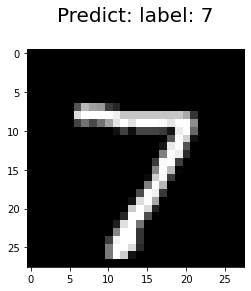

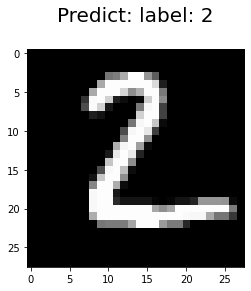

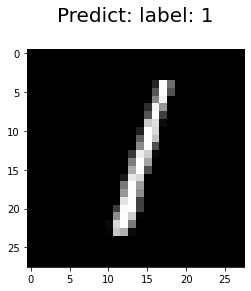

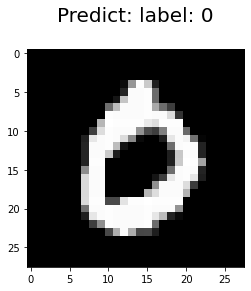

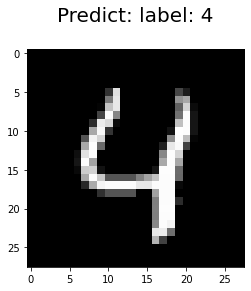

In [68]:
import matplotlib.pyplot as plt

def plt_mnist(x, y, plt_num=5):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(x[0:plt_num], y[0:plt_num])):
        plt.figure()
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('{}: label: {}\n'.format('Predict', label), fontsize = 20)

predict_ = trainer.model.predict(x_test)
predict = [tf.argmax(e).numpy() for e in predict_]
plt_mnist(x_test, predict)

# TF2 MNIST 手寫 - 方式 2 

In [133]:
#範例2 : https://weikaiwei.com/tf/tensorflow-2-mnist-2/
#https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/cnn-functional-2.1.1.py
#---------------------------------------------------------------------------------------------------------------
# 讀取手寫識別數據
#---------------------------------------------------------------------------------------------------------------
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np 
import os
from MNIST_data import input_data
mnist = input_data.read_data_sets("D:\Python\Tensorflow\MNIST_data" , one_hot=True)

print('\nLoading MNIST DataBase\n',
      'train number=',mnist.train.num_examples,"\n", 'vakidation number=',mnist.validation.num_examples,"\n",
      'test number=',mnist.test.num_examples,"\n", 'train image shape', mnist.train.images.shape,"\n",
      'label image shape', mnist.train.labels.shape,"\n", 'train image size' , mnist.train.images[0].size,"\n")


#---------------------------------------------------------------------------------------------------------------
# 建立 卷積神經網路(動態圖)
#---------------------------------------------------------------------------------------------------------------
inputs_ = layers.Input(shape=(28, 28,1))
C1_Conv = layers.Conv2D(filters=16,kernel_size=5, activation='relu')(inputs_)
C1_Pool = layers.MaxPooling2D(2, 2)(C1_Conv)
C2_Conv = layers.Conv2D(32, 5, activation = tf.nn.relu)(C1_Pool)
C2_Pool = layers.MaxPooling2D(2, 2)(C2_Conv)
flat1   = layers.Flatten()(C2_Pool)
Dense1  = layers.Dense(128, activation = tf.nn.relu)(flat1)
Dropout = layers.Dropout(0.3)(Dense1)
outputs = layers.Dense(10, activation="softmax")(Dropout)
model   = tf.keras.Model(inputs=inputs_, outputs=outputs)

#---------------------------------------------------------------------------------------------------------------
# 建立卷積神經網路(訓練模型)
#---------------------------------------------------------------------------------------------------------------

#建構訓練資料
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32).reshape(-1, 28, 28) 
x_train = np.expand_dims(x_train, axis=3)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

x_test = x_test.astype(np.float32).reshape(-1, 28, 28) 
x_test = np.expand_dims(x_test, axis=3)
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset  = test_dataset.batch(128)

#設定訓練網路(函式、變數)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function #啟動動態圖
def test_step(images, labels):
    # forward pass to get predictions
    predictions = model(images)
    # compute loss with the ground and our predictions
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

#開始訓練模型 tranning model
epoch_list=[];accuracy_list=[];loss_list=[];    
for epoch in range(20):
    for image, label in train_dataset:
        train_step(image, label)
        
    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)    
        
    template = 'Epoch {}, Loss: {:.9f}, Accuracy: {}, Test Loss: {:.9f}, Test Accuracy: {}\n'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
    epoch_list.append(epoch)
    loss_list.append(format(train_loss.result()))
    accuracy_list.append(format(train_accuracy.result()))
    
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()   

weilly
Extracting D:\Python\Tensorflow\MNIST_data\train-images-idx3-ubyte.gz
Extracting D:\Python\Tensorflow\MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:\Python\Tensorflow\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:\Python\Tensorflow\MNIST_data\t10k-labels-idx1-ubyte.gz

Loading MNIST DataBase
 train number= 55000 
 vakidation number= 5000 
 test number= 10000 
 train image shape (55000, 784) 
 label image shape (55000, 10) 
 train image size 784 

Epoch 1, Loss: 0.968518078, Accuracy: 0.8912333250045776, Test Loss: 0.135088325, Test Accuracy: 0.9591000080108643

Epoch 2, Loss: 0.100857645, Accuracy: 0.9713833332061768, Test Loss: 0.085203849, Test Accuracy: 0.975600004196167

Epoch 3, Loss: 0.059101537, Accuracy: 0.9824666380882263, Test Loss: 0.075706191, Test Accuracy: 0.9782000184059143

Epoch 4, Loss: 0.040149245, Accuracy: 0.9876000285148621, Test Loss: 0.068410873, Test Accuracy: 0.9811000227928162

Epoch 5, Loss: 0.029953759, Accuracy: 0.9901833534240723, Test Los

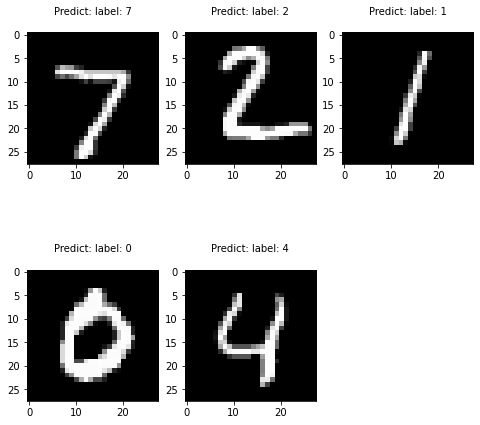

In [134]:
import matplotlib.pyplot as plt

def plt_mnist(x, y, plt_num=5):
    plt.figure(figsize=(8,8))
    for index, (image, label) in enumerate(zip(x[0:plt_num], y[0:plt_num])):
        #plt.figure()
        plt.subplot(2, 3, (index+1))
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('{}: label: {}\n'.format('Predict', label), fontsize = 10)

predict_ = model.predict(x_test)
predict = [tf.argmax(e).numpy() for e in predict_]
plt_mnist(x_test, predict)

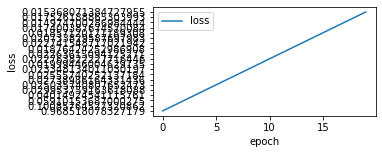

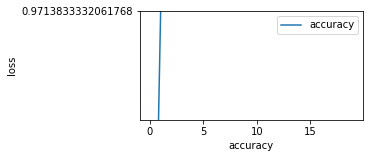

Predict Neural Network 
 -------------------------------------------



In [135]:
#---------------------------------------------------------------------------------------------------------------
# 預測結果
#---------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# 顯示測試影像與正確的預測結果
img_w = 28;img_h = 28
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf() #開畫布
    fig.set_size_inches(12,14)
    if num>25 : num=25
    for i in range(0,num):
        ax = plt.subplot(5,5,1+i) #選擇畫布內的位置
        ax.imshow(np.reshape(images[idx],(img_w,img_h)),cmap='binary') #顯示影像
        title = "label="+str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title+=",predict"+str(prediction[idx])
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.show()

# 顯示測試影像與錯誤的預測結果
def show_images_labels_predict_error(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    i=0;j=0
    while i<10:
        if prediction_result[j]!=np.argmax(labels[j]):
            ax=plt.subplot(5,5, 1+i)
            ax.imshow(np.reshape(images[j],(28, 28)), cmap='binary')
            ax.set_title("j="+str(j)+",l=" +str(np.argmax(labels[j]))+",p="+str(prediction_result[j]),fontsize=9) 
            i=i+1  
        j=j+1
    plt.show()   
# 繪出損失曲線
def plot_loss_function(epoch_list, loss_list):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.gcf()
    fig.set_size_inches(4,2)
    plt.plot(epoch_list,loss_list,label='loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss'],loc='upper left')
    plt.show()

# 繪出準確曲線
def plot_accuracy( epoch_list, accuracy_list):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.gcf()
    fig.set_size_inches(4,2)
    plt.plot(epoch_list,accuracy_list,label='accuracy')
    plt.ylim(0.8,1)
    plt.ylabel('loss')
    plt.xlabel('accuracy')
    plt.legend()
    plt.show()

#繪出損失曲線與準確度
plot_loss_function(epoch_list, loss_list)
plot_accuracy(epoch_list, accuracy_list) 
#print(loss_list)

#預測結果
print('Predict Neural Network \n','-------------------------------------------\n')
#prediction_result=sess.run(tf.argmax(y_predict,1),feed_dict={x: mnist.test.images ,y_label: mnist.test.labels})
#plot_images_labels_prediction(mnist.test.images, mnist.test.labels,prediction_result,0) #顯示前 10 筆


In [139]:
#---------------------------------------------------------------------------------------------------------------
# 儲存模組
#---------------------------------------------------------------------------------------------------------------
tf.saved_model.save(model, "Tensorflow_2_HandWrite")

INFO:tensorflow:Assets written to: Tensorflow_2_HandWrite\assets


In [146]:
#---------------------------------------------------------------------------------------------------------------
# 轉成 Tensorflow Lite
#---------------------------------------------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
def representative_dataset_gen():
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 28, 28, 1)).astype(np.float32)] #需要輸入端大小
        
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model("Tensorflow_2_HandWrite")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type   = tf.uint8
converter.inference_output_type  = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with open('tf2_handwrite_model_qunat_uint8.tflite','wb') as f:
    f.write(tflite_model)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from Tensorflow_2_HandWrite\variables\variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1
INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 28, 28, 1), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from Tensorflow_2_HandWrite\variables\variables
Instructions for updating:
Use `tf.compat.v1.g

Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the f

# TF2 Keras

In [155]:
#---------------------------------------------------------------------------------------------------------------
# 載入函式庫
#---------------------------------------------------------------------------------------------------------------
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Conv2D
import numpy as np

#---------------------------------------------------------------------------------------------------------------
# 讀取手寫識別數據
#---------------------------------------------------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28,28,1).astype('float32') /255
x_test  = x_test.reshape(10000, 28,28,1).astype('float32') /255
print('\nLoading MNIST DataBase\n',
      'train number =',x_train.shape[0],"\n", 'test  number =',x_test.shape[0],"\n", 
      'train image shape', x_train.shape,"\n",'label image shape', y_train.shape,"\n", 
      'train image size' , x_train.shape[1]*x_train.shape[2],"\n")


#---------------------------------------------------------------------------------------------------------------
# 將標籤轉換為熱編碼(hot-code)
#---------------------------------------------------------------------------------------------------------------
num_classes = 10
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

#---------------------------------------------------------------------------------------------------------------
# 建立神經網路架構
#---------------------------------------------------------------------------------------------------------------
model = Sequential()
model.add(Conv2D(filters=16,kernel_size=(5,5),padding='same',input_shape=(28,28,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=36,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))

#---------------------------------------------------------------------------------------------------------------
# 訓練神經網路架構
#---------------------------------------------------------------------------------------------------------------
#最佳化設定 optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#fit
batch_size = 100
epochs = 10
history = model.fit(x_train, y_train_onehot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_onehot))


Loading MNIST DataBase
 train number = 60000 
 test  number = 10000 
 train image shape (60000, 28, 28, 1) 
 label image shape (60000,) 
 train image size 784 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 31s 509us/step - loss: 0.1824 - accuracy: 0.9452 - val_loss: 0.0643 - val_accuracy: 0.9782
Epoch 2/10
60000/60000 [==============================] - 37s 614us/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.0384 - val_accuracy: 0.9871
Epoch 3/10
60000/60000 [==============================] - 36s 603us/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0329 - val_accuracy: 0.9887
Epoch 4/10
60000/60000 [==============================] - 37s 624us/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0295 - val_accuracy: 0.9912
Epoch 5/10
60000/60000 [==============================] - 40s 660us/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.0283 - val_accuracy: 0.9910
Epoch 6/10
60000/60000 [===================

In [123]:
#---------------------------------------------------------------------------------------------------------------
# 顯示熱編碼
#---------------------------------------------------------------------------------------------------------------
print(y_train[:10])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [88]:
#---------------------------------------------------------------------------------------------------------------
# 顯示模組架構
#---------------------------------------------------------------------------------------------------------------
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 36)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1764)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)             

10000/10000 [==============================] - 1s 135us/step
accuracy= 0.9919999837875366


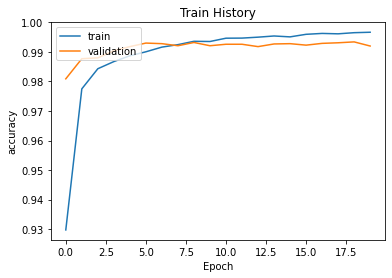

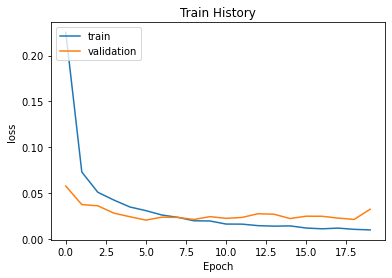

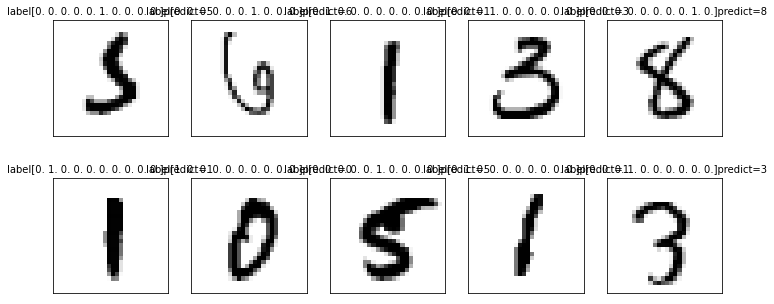

In [131]:
#---------------------------------------------------------------------------------------------------------------
# 計算準確度
#---------------------------------------------------------------------------------------------------------------
scores = model.evaluate(x_test,y_test)
print('accuracy=',scores[1])

#---------------------------------------------------------------------------------------------------------------
# 顯示訓練過程
#---------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

    
show_train_history(history,'accuracy','val_accuracy')   
show_train_history(history,'loss','val_loss')

#---------------------------------------------------------------------------------------------------------------
# 預測結果
#---------------------------------------------------------------------------------------------------------------
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,14)
    images_reshape = images.reshape(images.shape[0], 28,28)
    if num>25: num = 25
    for i in range(0,num):
        ax = plt.subplot(5,5,i+1)
        ax.imshow(images_reshape[idx],cmap='binary')
        title = "label"+str(labels[idx])
        if len(prediction)>0:
            title+="predict="+str(prediction[idx])
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.show()
                     
prediction = model.predict_classes(x_test)
plot_images_labels_prediction(x_test, y_test,prediction, idx=340)

In [144]:
#---------------------------------------------------------------------------------------------------------------
# 儲存模組
#---------------------------------------------------------------------------------------------------------------
model.save('./tf2_keras_handwrite.h5')

In [172]:
#---------------------------------------------------------------------------------------------------------------
# 轉成 Tensorflow Lite
#---------------------------------------------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
def representative_dataset_gen():
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 28, 28, 1)).astype(np.float32)] #需要輸入端大小
        
#model=model.load_weights('tf2_keras_handwrite.h5')
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('tf2_keras_handwrite.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with open('keras_handwrite_model_qunat_uint8.tflite','wb') as f:
    f.write(tflite_model)


In [170]:
#save
open('tf2_keras_handwrite.json', 'w').write(model.to_json())

#load
from keras.models import model_from_json
model = model_from_json(open('tf2_keras_handwrite.json').read())